# ArcGIS API for Python: AIS Route Extraction Prototype

## A collaboration between the U.S. Department of Transportation and Esri

###### Alberto Nieto (Esri), Andrew Barrows (USDOT), Dominic Menegus (USDOT)

This Jupyter Notebook contains documentation, processing, and data visualization of a process in which the Automated Identification System (AIS) vessel data for specified terminal-to-terminal connections is used to digitize a route polyline dataset for an authoritative GIS. 

This process can be leveraged to develop an Information Product that generates data-driven ferry routes for all terminals in the United States, and could be extended to other environments and use cases.

Contact Info:
anieto@esri.com

# Spatial Analysis Methodology

### 1. Ask questions: 
Formulate hypotheses and spatial
questions.

### 2. Explore the data: 
Examine the data quality,
completeness, and measurement limitations (scale
and resolution) to determine the level of analysis and
interpretation that can be supported.

### 3. Analyze and model: 
Break the problem down into
solvable components that can be modeled. Quantify
and evaluate the spatial questions.

### 4. Interpret the results: 
Evaluate and analyze the results
in the context of the question posed, data limitations,
accuracy, and other implications.

### 5. Repeat as necessary: 
Spatial analysis is a continuous
and iterative process that often leads to further
questions and refinements.

### 6. Present the results: 
The best information and
analysis becomes increasingly valuable when it can be
effectively presented and shared with a larger audience.

### 7. Make a decision: 

Spatial analysis and GIS are used to support the 
decision-making process. A successful spatial analysis 
process often leads to the understanding necessary to 
drive decisions and action.

# 1. Ask Questions

### Where are the ferry routes in the United States?

# 2. Retrieve and Explore Data

This cell imports a few modules needed for this process

In [44]:
import arcgis  # The ArcGIS API for Python
import arcpy  # The Arcpy module used for local spatial analysis
import pandas as pd  # The pandas module to easily manage data in python memory

import plotly

import matplotlib.pyplot as plt  # The matplotlib library to produce plots
import seaborn  # The seaborn library to spice up our plots
from scipy.stats import norm  # Scipy stats library for general statistical functions
%matplotlib inline  

Establish our environment, specifying a directory where we will work from

In [2]:
root = r'C:\Users\albe9057\Documents\GitHub\AISFerryRouteDigitization_Prototype\inputs' 
arcpy.env.workspace = root
arcpy.env.overwriteOutput = True

Set reference to a GIS and connect using the ArcGIS API for Python

In [3]:
portals_dict = {
    "esrifederal_gis": r"https://esrifederal.maps.arcgis.com",
    "natgov_gis": r"http://esri-natgov105.eastus.cloudapp.azure.com/arcgis",
    "dot_gis": r"http://dot.esri.com/portal",
    "dev_gis": r"http://govdev.eastus.cloudapp.azure.com/arcgis",
    "local_gis": r"https://anieto.esri.com/arcgis",
    "science_agol_org": r"https://science.maps.arcgis.com"
}

gis_url = portals_dict["esrifederal_gis"]

if gis_url == portals_dict["esrifederal_gis"]:
#     gis_app_id = getpass.getpass(prompt="App ID: ")
    gis_app_id = r"wt3QUR1M4eum0TVI"
    print("Attempting to log in to '{0}'...".format(gis_url))
    gis = arcgis.gis.GIS(gis_url, client_id=gis_app_id)
    print("Successfully logged in as: " + gis.properties.user.username)
else:
    gis_username = getpass.getpass(prompt="Username: ")
    gis_pw = getpass.getpass(prompt="Password: ")
    print("Attempting to log in to '{0}'...".format(gis_url))
    gis = arcgis.gis.GIS(gis_url, gis_username, gis_pw, verify_cert=False)
    print("Successfully logged in as: " + gis.properties.user.username)

Attempting to log in to 'https://esrifederal.maps.arcgis.com'...
Please sign in to your GIS and paste the code that is obtained below.
If a web browser does not automatically open, please navigate to the URL below yourself instead.
Opening web browser to navigate to: https://esrifederal.maps.arcgis.com/sharing/rest/oauth2/authorize?client_id=wt3QUR1M4eum0TVI&response_type=code&expiration=-1&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob
Enter code obtained on signing in using SAML: ········
Successfully logged in as: albe9057@esri.com_esrifederal


Set reference to the source URL for downloading publicly available AIS data

In [4]:
ais_source_url = r"https://marinecadastre.gov/ais/"

#### Establish target ferry routes service

Set reference to an existing Feature Service that will contain the output ferry routes produced in this process

<Item title:"AIS_SIFerryRoute_PreQC" type:Feature Layer Collection owner:albe9057@esri.com_esrifederal>
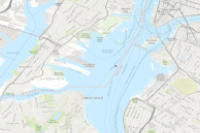

In [5]:
preqc_ferry_routes_item = gis.content.search("AIS_SIFerryRoute_PreQC", item_type='Feature Service')[0]
preqc_ferry_routes_item

<Item title:"AIS_SIFerryRoute_PostQC" type:Feature Layer Collection owner:albe9057@esri.com_esrifederal>
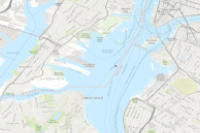

In [55]:
postqc_ferry_routes_item = gis.content.search("AIS_SIFerryRoute_PostQC", item_type='Feature Service')[0]
postqc_ferry_routes_item

In [6]:
# TODO: Establish iteration loop over different MMSIs
mmsi = [""]

In [7]:
# TODO: Establish MMSI iteration loop from Excel/CSV
mmsi_csv = r""

Set reference to the needed UTM zone and date for AIS data download

In [8]:
utm_zone = "18"
yyyy = "2014"
mm = "07"
date_yyyy_mm = "2014_07"
name_stamp = "Zone{0}_{1}".format(utm_zone, date_yyyy_mm)

In [9]:
ais_2014_sample_url = r"https://coast.noaa.gov/htdata/CMSP/AISDataHandler/{0}/{1}/Zone{2}_{0}_{1}.zip".format(yyyy, mm, utm_zone)
ais_2014_sample_url

'https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2014/07/Zone18_2014_07.zip'

Set reference to local paths for downloaded data for prototyping and testing

In [10]:
ais_local_fgdb = r"D:\ANieto_SolutionEngineer\Data\DOT\BTS\Zone18_2014_07\Zone18_2014_07.gdb"
ais_broadcast_fc = "{0}//Zone18_2014_07_Broadcast".format(ais_local_fgdb)
ais_vessel_table = "{0}//Zone18_2014_07_Vessel".format(ais_local_fgdb)
ais_voyage_table = "{0}//Zone18_2014_07_Voyage".format(ais_local_fgdb)
ais_sample_fc = "{0}//AIS_Sampler".format(ais_local_fgdb)

#### P1. Convert AIS source dataset into format that can be passed into generalization function

Convert the feature class of AIS data into a Spatial Dataframe, a python memory table with reference to geometry

In [11]:
# Add latitude and longitude attributes to the input feature class
ais_sdf = arcgis.features.SpatialDataFrame.from_featureclass(ais_sample_fc)
ais_sdf

,OBJECTID,SOG,COG,Heading,ROT,BaseDateTime,Status,VoyageID,MMSI,ReceiverType,ReceiverID,SHAPE
0,1,0.0,292.0,243.0,0.0,2014-07-01 00:00:02.000000,0,7,367019000,b,2003669982,"{'x': -74.071757, 'y': 40.64426499999999, 'spa..."
1,2,0.0,292.0,243.0,0.0,2014-07-01 00:01:02.000000,0,7,367019000,b,2003669982,"{'x': -74.071813, 'y': 40.64412200000001, 'spa..."
2,3,0.0,292.0,243.0,0.0,2014-07-01 00:02:02.000000,0,7,367019000,b,2003669982,"{'x': -74.071802, 'y': 40.64416299999999, 'spa..."
3,4,0.0,292.0,243.0,0.0,2014-07-01 00:03:02.000000,0,7,367019000,b,2003669982,"{'x': -74.071812, 'y': 40.64414199999999, 'spa..."
4,5,0.0,292.0,244.0,0.0,2014-07-01 00:04:02.000000,0,7,367019000,b,2003669982,"{'x': -74.071825, 'y': 40.644149999999996, 'sp..."
5,6,0.0,292.0,244.0,0.0,2014-07-01 00:05:02.000000,0,7,367019000,b,2003669982,"{'x': -74.07182, 'y': 40.644135000000006, 'spa..."
6,7,0.0,292.0,244.0,0.0,2014-07-01 00:06:02.000000,0,7,367019000,b,003669984,"{'x': -74.071818, 'y': 40.64414199999999, 'spa..."
7,8,0.0,292.0,245.0,0.0,2014-07-01 00:07:02.000000,0,7,367019000,b,2003669982,"{'x': -74.071817, 'y': 40.64410000000001, 'spa..."
8,9,0.0,292.0,245.0,0.0,2014-07-01 00:08:02.000000,0,7,367019000,b,2003669982,"{'x': -74.071768, 'y': 40.644115, 'spatialRefe..."
9,10,0.0,292.0,245.0,0.0,2014-07-01 00:09:02.000000,0,7,367019000,b,003669984,"{'x': -74.071723, 'y': 40.64408800000001, 'spa..."


Helper function used to calculate Latitude and Longitude from a Spatial Dataframe's SHAPE field

In [12]:
def calculate_lat_lon_in_spatialdf(spatialdf, shape_field='SHAPE', output_lat='latitude', output_lon='longitude'):

    def calculate_latitude(shape_field):
        return shape_field['y']

    def calculate_longitude(shape_field):
        return shape_field['x']

    # Calculate latitude and longitude fields from the shape attribute
    spatialdf[output_lat] = spatialdf.apply(lambda x: calculate_latitude(x[shape_field]), axis=1)
    spatialdf[output_lon] = spatialdf.apply(lambda x: calculate_longitude(x[shape_field]), axis=1)

    return spatialdf

In [13]:
# Calculate latitude and longitude fields from the shape attribute
ais_sdf = calculate_lat_lon_in_spatialdf(ais_sdf)
ais_sdf

,OBJECTID,SOG,COG,Heading,ROT,BaseDateTime,Status,VoyageID,MMSI,ReceiverType,ReceiverID,SHAPE,latitude,longitude
0,1,0.0,292.0,243.0,0.0,2014-07-01 00:00:02.000000,0,7,367019000,b,2003669982,"{'x': -74.071757, 'y': 40.64426499999999, 'spa...",40.644265,-74.071757
1,2,0.0,292.0,243.0,0.0,2014-07-01 00:01:02.000000,0,7,367019000,b,2003669982,"{'x': -74.071813, 'y': 40.64412200000001, 'spa...",40.644122,-74.071813
2,3,0.0,292.0,243.0,0.0,2014-07-01 00:02:02.000000,0,7,367019000,b,2003669982,"{'x': -74.071802, 'y': 40.64416299999999, 'spa...",40.644163,-74.071802
3,4,0.0,292.0,243.0,0.0,2014-07-01 00:03:02.000000,0,7,367019000,b,2003669982,"{'x': -74.071812, 'y': 40.64414199999999, 'spa...",40.644142,-74.071812
4,5,0.0,292.0,244.0,0.0,2014-07-01 00:04:02.000000,0,7,367019000,b,2003669982,"{'x': -74.071825, 'y': 40.644149999999996, 'sp...",40.644150,-74.071825
5,6,0.0,292.0,244.0,0.0,2014-07-01 00:05:02.000000,0,7,367019000,b,2003669982,"{'x': -74.07182, 'y': 40.644135000000006, 'spa...",40.644135,-74.071820
6,7,0.0,292.0,244.0,0.0,2014-07-01 00:06:02.000000,0,7,367019000,b,003669984,"{'x': -74.071818, 'y': 40.64414199999999, 'spa...",40.644142,-74.071818
7,8,0.0,292.0,245.0,0.0,2014-07-01 00:07:02.000000,0,7,367019000,b,2003669982,"{'x': -74.071817, 'y': 40.64410000000001, 'spa...",40.644100,-74.071817
8,9,0.0,292.0,245.0,0.0,2014-07-01 00:08:02.000000,0,7,367019000,b,2003669982,"{'x': -74.071768, 'y': 40.644115, 'spatialRefe...",40.644115,-74.071768
9,10,0.0,292.0,245.0,0.0,2014-07-01 00:09:02.000000,0,7,367019000,b,003669984,"{'x': -74.071723, 'y': 40.64408800000001, 'spa...",40.644088,-74.071723


Store the AIS dataframe as a csv

In [24]:
ais_sdf.to_csv("{0}//ais_sampler.csv".format(root))
                                 
ais_sampler_csv = "{0}//ais_sampler.csv".format(root)
ais_sampler_csv

'C:\\Users\\albe9057\\Documents\\GitHub\\AISFerryRouteDigitization_Prototype\\inputs//ais_sampler.csv'

##### Publishing Process: Publish AIS data to the GIS

To publish a new Feature Service from a Spatial Dataframe, export the dataframe to local disk as a CSV, then publish the item using the ArcGIS API for Python

In [ ]:
try:
    ais_sampler_csv_item = gis.content.add({}, ais_sampler_csv)
except RuntimeError:
    ais_sampler_csv_item = gis.content.search("AIS_StatenIsland_Sample")[0]
    
ais_sampler_csv_item

In [ ]:
try:
    ais_sampler_lyr = ais_sampler_csv_item.publish()
except RuntimeError:
    ais_sampler_lyr = gis.content.search("AIS_StatenIsland_Sample")[0]
    
ais_sampler_lyr

In [25]:
ais_sampler_lyr = gis.content.search("AIS_StatenIsland_Sample", item_type="feature layer")[0]
ais_sampler_lyr

<Item title:"AIS_StatenIsland_Sample" type:Feature Layer Collection owner:albe9057@esri.com_esrifederal>

Load the published data into a map

In [30]:
ais_sampler_map = gis.map("New York City")
ais_sampler_map.add_layer(ais_sampler_lyr)
ais_sampler_map.basemap = "dark-grey"
ais_sampler_map

# 3. Analyze and Model

#### P2. Run generalization function and visualize outputs

We will use plotly to plot the AIS inputs and the outputs of the generalization function. Plotly contains an offline and an online mode. For this example, we will invoke a local plotting session and explore how the analysis is performing. 

In [22]:
# Offline plotly
import plotly

plotly.offline.plot({
    "data": [plotly.graph_objs.Scatter(x=ais_sdf['longitude'], y=ais_sdf['latitude'])]
})

'file://C:\\Users\\albe9057\\Documents\\GitHub\\AISFerryRouteDigitization_Prototype\\scripts\\prototype\\temp-plot.html'

The generalization function uses locally weighted regression (LOWESS), a method for smoothing a scatterplot. 

In [14]:
# Compute lowess 
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

x = ais_sdf['longitude']
y = ais_sdf['latitude']

z = lowess(y, x)
z

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


array([[-74.073435  ,  40.64370883],
       [-74.073357  ,  40.6437377 ],
       [-74.073347  ,  40.6437414 ],
       ..., 
       [-74.008507  ,  40.70564999],
       [-74.008172  ,  40.70596907],
       [-74.00772   ,  40.70639922]])

The next two cells are used to plot the inputs and outputs of the LOWESS function

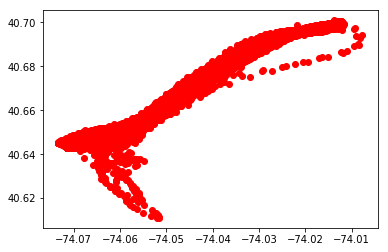

In [15]:
plt.plot(ais_sdf['longitude'], ais_sdf['latitude'], 'ro')
plt.show()

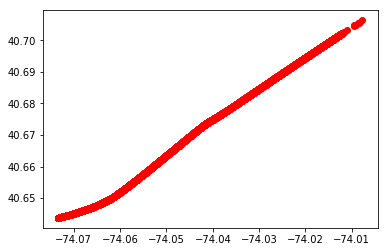

In [16]:
plt.plot(z[:,0], z[:,1], 'ro')
plt.show()

We can also use Plotly to demonstrate the output of the LOWESS function...

In [26]:
plotly.offline.plot({
    "data": [plotly.graph_objs.Scatter(x=z[:,0], y=z[:,1])]
})

'file://C:\\Users\\albe9057\\Documents\\GitHub\\AISFerryRouteDigitization_Prototype\\scripts\\prototype\\temp-plot.html'

In [27]:
plotly.plotly.iplot({
    "data": [plotly.graph_objs.Scatter(x=z[:,0], y=z[:,1])]
})

In [28]:
ais_points = plotly.graph_objs.Scatter(
    x = ais_sdf['longitude'],
    y = ais_sdf['latitude'],
    name = 'ais'
)

In [29]:
lowess_trace = plotly.graph_objs.Scatter(
    x = z[:,0],
    y = z[:,1],
    name = 'lowess'
)

In [30]:
data = [ais_points, lowess_trace]
fig = dict(data=data)

In [31]:
# Online
plotly.plotly.iplot(fig, filename='lowess_01')

The draw time for this plot will be slow for clients without much RAM.


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\plotly\api\v1\clientresp.py:40: UserWarning:

Estimated Draw Time Slow



In [32]:
# Offline
plotly.offline.plot(fig, filename='lowess_01')

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\plotly\offline\offline.py:459: UserWarning:

Your filename `lowess_01` didn't end with .html. Adding .html to the end of your file.



'file://C:\\Users\\albe9057\\Documents\\GitHub\\AISFerryRouteDigitization_Prototype\\scripts\\prototype\\lowess_01.html'

#### P2: Convert geometry from lowess generalization function to a polyline geometry

We now need to build a ferry route feature for a feature service. This cell produces a nested list from the LOWESS outputs that will be used as geometry. 

In [17]:
route_geometry = [z.tolist()]  # We need a nested list for the geometry
route_geometry

[[[-74.073435, 40.643708826790096],
  [-74.073357, 40.64373770209093],
  [-74.073347, 40.64374140393686],
  [-74.073338, 40.64374475429137],
  [-74.073338, 40.64374475429137],
  [-74.073335, 40.6437458803821],
  [-74.073335, 40.6437458803821],
  [-74.073333, 40.64374661540007],
  [-74.073333, 40.64374661540007],
  [-74.073332, 40.64374698136773],
  [-74.073332, 40.64374698136773],
  [-74.073332, 40.64374698136773],
  [-74.073332, 40.64374698136773],
  [-74.07333, 40.64374773990372],
  [-74.07333, 40.64374773990372],
  [-74.07333, 40.64374773990372],
  [-74.07333, 40.64374773990372],
  [-74.073328, 40.64374847988174],
  [-74.073328, 40.64374847988174],
  [-74.073327, 40.643748839807664],
  [-74.073327, 40.643748839807664],
  [-74.073327, 40.643748839807664],
  [-74.073327, 40.643748839807664],
  [-74.073327, 40.643748839807664],
  [-74.073325, 40.643749585865855],
  [-74.073323, 40.643750335796256],
  [-74.073323, 40.643750335796256],
  [-74.073323, 40.643750335796256],
  [-74.073323, 4

We transfer the geometry to a polyline object, using a specified spatial reference...

In [18]:
line = {
    "paths" : route_geometry,
    "spatialReference" : {"wkid" : 4326}
}
ais_polyline = arcgis.geometry.Polyline(line)
print(ais_polyline)
print(ais_polyline.is_valid)

{"paths": [[[-74.073435, 40.643708826790096], [-74.073357, 40.64373770209093], [-74.073347, 40.64374140393686], [-74.073338, 40.64374475429137], [-74.073338, 40.64374475429137], [-74.073335, 40.6437458803821], [-74.073335, 40.6437458803821], [-74.073333, 40.64374661540007], [-74.073333, 40.64374661540007], [-74.073332, 40.64374698136773], [-74.073332, 40.64374698136773], [-74.073332, 40.64374698136773], [-74.073332, 40.64374698136773], [-74.07333, 40.64374773990372], [-74.07333, 40.64374773990372], [-74.07333, 40.64374773990372], [-74.07333, 40.64374773990372], [-74.073328, 40.64374847988174], [-74.073328, 40.64374847988174], [-74.073327, 40.643748839807664], [-74.073327, 40.643748839807664], [-74.073327, 40.643748839807664], [-74.073327, 40.643748839807664], [-74.073327, 40.643748839807664], [-74.073325, 40.643749585865855], [-74.073323, 40.643750335796256], [-74.073323, 40.643750335796256], [-74.073323, 40.643750335796256], [-74.073323, 40.643750335796256], [-74.073323, 40.6437503357

In this cell, we create an attribute dictionary to contain the attribute data that the ferry route will use.

In [19]:
attribute_dict = {"route_id": "test", 
                  "numeric_id": 999, 
                  "terminal_a": "Staten Island", 
                  "terminal_b": "Battery Park",
                  "utm_zone": "18",
                  "ais_month": "7",
                  "ais_year": "2014"
                 }

#### P3: Pass the generalized route's polyline geometry to an arcgis feature object

This cell contains the final feature, with geometry from the LOWESS outputs and attributes from the attribute dictionary above. 

In [20]:
ais_route_feature = arcgis.features.Feature(geometry=ais_polyline, attributes=attribute_dict)
ais_route_feature

{"geometry": {"paths": [[[-74.073435, 40.643708826790096], [-74.073357, 40.64373770209093], [-74.073347, 40.64374140393686], [-74.073338, 40.64374475429137], [-74.073338, 40.64374475429137], [-74.073335, 40.6437458803821], [-74.073335, 40.6437458803821], [-74.073333, 40.64374661540007], [-74.073333, 40.64374661540007], [-74.073332, 40.64374698136773], [-74.073332, 40.64374698136773], [-74.073332, 40.64374698136773], [-74.073332, 40.64374698136773], [-74.07333, 40.64374773990372], [-74.07333, 40.64374773990372], [-74.07333, 40.64374773990372], [-74.07333, 40.64374773990372], [-74.073328, 40.64374847988174], [-74.073328, 40.64374847988174], [-74.073327, 40.643748839807664], [-74.073327, 40.643748839807664], [-74.073327, 40.643748839807664], [-74.073327, 40.643748839807664], [-74.073327, 40.643748839807664], [-74.073325, 40.643749585865855], [-74.073323, 40.643750335796256], [-74.073323, 40.643750335796256], [-74.073323, 40.643750335796256], [-74.073323, 40.643750335796256], [-74.073323, 

We pass the feature to a list of features to add. If we choose to process multiple ferry routes, the list would contain each route processed by this notebook.

In [21]:
features_to_add = [ais_route_feature]

#### P4: Send the feature object to a feature service of ferry routes as an update

The following cells establish a link to the feature layer to contain the ferry routes, performing a quick query to determine which records were present before adding the ferry route, and confirming that the route was added. 

In [22]:
preqc_routes_flayer = preqc_ferry_routes_item.layers[0]

In [23]:
# Pre-addition
routes_fset = preqc_routes_flayer.query()
routes_fset.df.head()

,OBJECTID,Shape__Length,ais_month,ais_year,route_id,route_id_num,terminal_a,terminal_b,utm_zone,SHAPE
0,1,0.091514,7,2014,test,None,Staten Island,Battery Park,18,"{'paths': [[[-74.073435, 40.6437088267901], [-..."


In [24]:
preqc_routes_flayer.edit_features(adds = features_to_add)

{'addResults': [{'globalId': None, 'objectId': 2, 'success': True}],
 'deleteResults': [],
 'updateResults': []}

In [25]:
# Post-addition
routes_fset = preqc_routes_flayer.query() #querying without any conditions returns all the current features
routes_fset.df.head()

,OBJECTID,Shape__Length,ais_month,ais_year,route_id,route_id_num,terminal_a,terminal_b,utm_zone,SHAPE
0,1,0.091514,7,2014,test,None,Staten Island,Battery Park,18,"{'paths': [[[-74.073435, 40.6437088267901], [-..."
1,2,0.091514,7,2014,test,None,Staten Island,Battery Park,18,"{'paths': [[[-74.073435, 40.6437088267901], [-..."


Finally, we plot the output on a map:

In [26]:
ferry_route_map = gis.map("New York City")
ferry_route_map.basemap = 'oceans'
ferry_route_map.add_layer(preqc_ferry_routes_item)
ferry_route_map

#### P3. Terminal Noise QC Process

##### Approach: Density-based Clustering to Filter Out AIS Noise Records

Each ferry route contains vessel travel that may deviate from the typical passage. The purpose of this process step is to leverage a spatial statistics tool named "Density-based Clustering" to classify input data into clusters and noise. The classified clusters are indicative of the typical travel pattern along the ferry route, while the classified noise features will be filtered out of a new LOWESS run. 

<img src="../../docs/dbclustering.PNG"></img>

Set up workspace and confirm inputs for Density-based Clustering tool runs

In [27]:
workspace = r'C:\\Users\\albe9057\\Documents\\GitHub\\AISFerryRouteDigitization_Prototype\\inputs\\qc_clustering_btstest.gdb'

In [28]:
ais_sample_fc

'D:\\ANieto_SolutionEngineer\\Data\\DOT\\BTS\\Zone18_2014_07\\Zone18_2014_07.gdb//AIS_Sampler'

Invoke the Density-based Clustering tool via Arcpy

In [32]:
ais_sample_fc

'D:\\ANieto_SolutionEngineer\\Data\\DOT\\BTS\\Zone18_2014_07\\Zone18_2014_07.gdb//AIS_Sampler'

In [36]:
workspace

'C:\\\\Users\\\\albe9057\\\\Documents\\\\GitHub\\\\AISFerryRouteDigitization_Prototype\\\\inputs\\\\qc_clustering_btstest.gdb'

In [37]:
clustered_fc = arcpy.stats.DensityBasedClustering(ais_sample_fc, 
                                                  "{0}//{1}_OPTICS".format(workspace, name_stamp), 
                                                  "OPTICS", 
                                                  3, 
                                                  search_distance="50 Feet", 
                                                  cluster_sensitivity=1).getOutput(0)
clustered_fc

'C:\\\\Users\\\\albe9057\\\\Documents\\\\GitHub\\\\AISFerryRouteDigitization_Prototype\\\\inputs\\\\qc_clustering_btstest.gdb\\Zone18_2014_07_OPTICS'

<Item title:"OPTICS_AIS_Sampler_50ft_lowsens_FILTER_nonnoise" type:Feature Layer Collection owner:albe9057@esri.com_esrifederal>
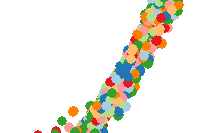

In [34]:
clustering_outputs = gis.content.search("OPTICS_AIS_Sampler_50ft_lowsens", item_type="feature layer")[0]
clustering_outputs

In [35]:
clustered_map = gis.map("New York City")
clustered_map.add_layer(clustering_outputs)
clustered_map

Read the clustering outputs into a spatial dataframe in python...

In [38]:
# Convert the output clusters to a spatial dataframe so we can filter the inputs by the clustering designations
clustered_sdf = arcgis.features.SpatialDataFrame.from_featureclass(clustered_fc)
clustered_sdf

,OBJECTID,SOURCE_ID,CLUSTER_ID,REACHORDER,REACHDIST,COLOR_ID,SHAPE
0,1,1,1,0,15.235027,7,"{'x': -74.071757, 'y': 40.64426499999999, 'spa..."
1,2,2,1,321,0.276992,7,"{'x': -74.071813, 'y': 40.64412200000001, 'spa..."
2,3,3,1,8,1.011813,7,"{'x': -74.071802, 'y': 40.64416299999999, 'spa..."
3,4,4,1,514,0.511563,7,"{'x': -74.071812, 'y': 40.64414199999999, 'spa..."
4,5,5,1,613,0.909100,7,"{'x': -74.071825, 'y': 40.644149999999996, 'sp..."
5,6,6,1,511,0.422930,7,"{'x': -74.07182, 'y': 40.644135000000006, 'spa..."
6,7,7,1,513,0.511563,7,"{'x': -74.071818, 'y': 40.64414199999999, 'spa..."
7,8,8,1,297,0.422931,7,"{'x': -74.071817, 'y': 40.64410000000001, 'spa..."
8,9,9,1,68,0.373634,7,"{'x': -74.071768, 'y': 40.644115, 'spatialRefe..."
9,10,10,1,486,0.561641,7,"{'x': -74.071723, 'y': 40.64408800000001, 'spa..."


... and select the features that were characterized as part of a cluster. 

In [39]:
# The noise corresponds to COLOR_ID == -1; let's filter it out of a copy of the original ais_sampler df
filtered_sdf = clustered_sdf.loc[clustered_sdf.COLOR_ID != -1]
filtered_sdf

,OBJECTID,SOURCE_ID,CLUSTER_ID,REACHORDER,REACHDIST,COLOR_ID,SHAPE
0,1,1,1,0,15.235027,7,"{'x': -74.071757, 'y': 40.64426499999999, 'spa..."
1,2,2,1,321,0.276992,7,"{'x': -74.071813, 'y': 40.64412200000001, 'spa..."
2,3,3,1,8,1.011813,7,"{'x': -74.071802, 'y': 40.64416299999999, 'spa..."
3,4,4,1,514,0.511563,7,"{'x': -74.071812, 'y': 40.64414199999999, 'spa..."
4,5,5,1,613,0.909100,7,"{'x': -74.071825, 'y': 40.644149999999996, 'sp..."
5,6,6,1,511,0.422930,7,"{'x': -74.07182, 'y': 40.644135000000006, 'spa..."
6,7,7,1,513,0.511563,7,"{'x': -74.071818, 'y': 40.64414199999999, 'spa..."
7,8,8,1,297,0.422931,7,"{'x': -74.071817, 'y': 40.64410000000001, 'spa..."
8,9,9,1,68,0.373634,7,"{'x': -74.071768, 'y': 40.644115, 'spatialRefe..."
9,10,10,1,486,0.561641,7,"{'x': -74.071723, 'y': 40.64408800000001, 'spa..."


Finally, determine how many features were removed due to being characterized as noise. 

In [40]:
print("Removed {0} AIS points using Density-based Clustering QC process...".format(str(clustered_sdf.shape[0] - filtered_sdf.shape[0])))

Removed 3786 AIS points using Density-based Clustering QC process...


#### P4. Repeat lowess process with new clustered data

With our clustered ship location features, we now repeat the process and allow the lowess function to execute on the filtered data.

In [45]:
filtered_sdf = calculate_lat_lon_in_spatialdf(filtered_sdf)
filtered_sdf

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,OBJECTID,SOURCE_ID,CLUSTER_ID,REACHORDER,REACHDIST,COLOR_ID,SHAPE,latitude,longitude
0,1,1,1,0,15.235027,7,"{'x': -74.071757, 'y': 40.64426499999999, 'spa...",40.644265,-74.071757
1,2,2,1,321,0.276992,7,"{'x': -74.071813, 'y': 40.64412200000001, 'spa...",40.644122,-74.071813
2,3,3,1,8,1.011813,7,"{'x': -74.071802, 'y': 40.64416299999999, 'spa...",40.644163,-74.071802
3,4,4,1,514,0.511563,7,"{'x': -74.071812, 'y': 40.64414199999999, 'spa...",40.644142,-74.071812
4,5,5,1,613,0.909100,7,"{'x': -74.071825, 'y': 40.644149999999996, 'sp...",40.644150,-74.071825
5,6,6,1,511,0.422930,7,"{'x': -74.07182, 'y': 40.644135000000006, 'spa...",40.644135,-74.071820
6,7,7,1,513,0.511563,7,"{'x': -74.071818, 'y': 40.64414199999999, 'spa...",40.644142,-74.071818
7,8,8,1,297,0.422931,7,"{'x': -74.071817, 'y': 40.64410000000001, 'spa...",40.644100,-74.071817
8,9,9,1,68,0.373634,7,"{'x': -74.071768, 'y': 40.644115, 'spatialRefe...",40.644115,-74.071768
9,10,10,1,486,0.561641,7,"{'x': -74.071723, 'y': 40.64408800000001, 'spa...",40.644088,-74.071723


In [46]:
plotly.offline.plot({
    "data": [plotly.graph_objs.Scatter(x=filtered_sdf['longitude'], y=filtered_sdf['latitude'])]
})

'file://C:\\Users\\albe9057\\Documents\\GitHub\\AISFerryRouteDigitization_Prototype\\scripts\\prototype\\temp-plot.html'

In [47]:
plotly.plotly.iplot({
    "data": [plotly.graph_objs.Scatter(x=filtered_sdf['longitude'], y=filtered_sdf['latitude'])]
})

In [48]:
# Compute lowess 
x = filtered_sdf['longitude']
y = filtered_sdf['latitude']

z = lowess(y, x)
z

array([[-74.073435  ,  40.64475999],
       [-74.073357  ,  40.64472944],
       [-74.073347  ,  40.64472552],
       ..., 
       [-74.012173  ,  40.70128378],
       [-74.012173  ,  40.70128378],
       [-74.012117  ,  40.70133912]])

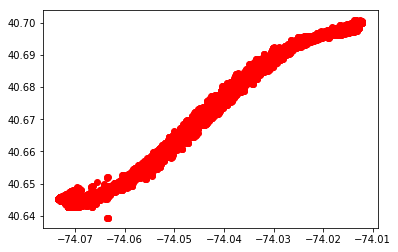

In [49]:
plt.plot(filtered_sdf['longitude'], filtered_sdf['latitude'], 'ro')
plt.show()

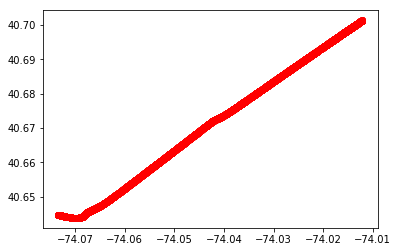

In [50]:
plt.plot(z[:,0], z[:,1], 'ro')
plt.show()

In [ ]:
plotly.offline.plot({
    "data": [plotly.graph_objs.Scatter(x=z[:,0], y=z[:,1])]
})

In [ ]:
plotly.plotly.iplot({
    "data": [plotly.graph_objs.Scatter(x=z[:,0], y=z[:,1])]
})

In [ ]:
ais_points = plotly.graph_objs.Scatter(
    x = filtered_sdf['longitude'],
    y = filtered_sdf['latitude'],
    name = 'ais'
)

In [ ]:
lowess_trace = plotly.graph_objs.Scatter(
    x = z[:,0],
    y = z[:,1],
    name = 'lowess'
)

In [ ]:
data = [ais_points, lowess_trace]
fig = dict(data=data)

In [ ]:
# Online
plotly.plotly.iplot(fig, filename='lowess_01')

In [ ]:
# Offline
plotly.offline.plot(fig, filename='lowess_01')

#### P5. Convert output generalization (+QC) output line to GIS format. Publish as a service. 

In [51]:
route_geometry = [z.tolist()]  # We need a nested list for the geometry
line = {
    "paths" : route_geometry,
    "spatialReference" : {"wkid" : 4326}
}
ais_polyline = arcgis.geometry.Polyline(line)

#### P3: Pass the generalized route's polyline geometry to an arcgis feature object

In [52]:
# Establish post-qc attributes
post_qc_attr_dict = attribute_dict
post_qc_attr_dict['route_id'] = "postqc_test_dbscan"
post_qc_attr_dict['numeric_id'] = 998
post_qc_attr_dict

{'ais_month': '7',
 'ais_year': '2014',
 'numeric_id': 998,
 'route_id': 'postqc_test_dbscan',
 'terminal_a': 'Staten Island',
 'terminal_b': 'Battery Park',
 'utm_zone': '18'}

In [53]:
ais_route_feature = arcgis.features.Feature(geometry=ais_polyline, attributes=post_qc_attr_dict)

In [54]:
features_to_add = [ais_route_feature]

#### P4: Send the feature object to a feature service of ferry routes as an update

In [58]:
postqc_routes_flayer = postqc_ferry_routes_item.layers[0]
postqc_routes_flayer

<FeatureLayer url:"https://services.arcgis.com/hRUr1F8lE8Jq2uJo/arcgis/rest/services/AIS_SIFerryRoute_PostQC/FeatureServer/0">

In [59]:
# Pre-addition
postqc_routes_fset = postqc_routes_flayer.query()
postqc_routes_fset.df.head()

""


In [60]:
postqc_routes_flayer.edit_features(adds = features_to_add)

{'addResults': [{'globalId': None, 'objectId': 1, 'success': True}],
 'deleteResults': [],
 'updateResults': []}

In [61]:
# Post-addition
postqc_routes_fset = postqc_routes_flayer.query() #querying without any conditions returns all the current features
postqc_routes_fset.df.head()

,OBJECTID,Shape__Length,ais_month,ais_year,route_id,route_id_num,terminal_a,terminal_b,utm_zone,SHAPE
0,1,0.085543,7,2014,postqc_test_dbscan,None,Staten Island,Battery Park,18,"{'paths': [[[-74.073435, 40.6447599885769], [-..."


In [63]:
ferry_route_map = gis.map("Staten Island, NY")
ferry_route_map.basemap = "ocean"
ferry_route_map.add_layer(postqc_ferry_routes_item)
ferry_route_map

In [64]:
ferry_route_map.center = [40.67295, -74.0442657]

In [65]:
ferry_route_map.zoom = 14

### Create MMSI Iteration

In [ ]:
# Set baseline AIS data source
ais_broadcast_fc

In [ ]:
# Retrieve a few MMSIs that can be found in the source fc
mmsi_list = ["367019000", "367042040"]

Testing single query

In [ ]:
fields = [f.name for f in arcpy.ListFields(ais_broadcast_fc)]
fields

In [ ]:
# Set query
ais_where_clause = "{0} = {1}".format(arcpy.AddFieldDelimiters(ais_broadcast_fc, 'MMSI'), mmsi_list[0])
ais_where_clause

In [ ]:
workspace

In [ ]:
# Extract version of source fc with query applied
ais_queried_fc = arcpy.Select_analysis(ais_broadcast_fc, workspace+"//ais_{0}".format(mmsi_list[0]), where_clause=ais_where_clause)
ais_queried_fc

Iteration loop

In [ ]:
for mmsi in mmsi_list:
    print("\nProcessing MMSI '{0}'...".format(str(mmsi)))
    # Set query
    ais_where_clause = "{0} = {1}".format(arcpy.AddFieldDelimiters(ais_broadcast_fc, 'MMSI'), mmsi)
    ais_queried_fc = arcpy.Select_analysis(ais_broadcast_fc, workspace+"//ais_{0}".format(mmsi_list[0]), where_clause=ais_where_clause)